In [1262]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CELL_LENGTH_M=7.5
TIME_STEP_S=1.6
print(f"Stałe fizyczne: Długość komórki = {CELL_LENGTH_M} m, Krok czasu = {TIME_STEP_S} s")

# --- Ustawienia Wykresów ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8) # Domyślnie większe wykresy
print("\nUstawiono style wykresów. Komórka 1 gotowa.")

Stałe fizyczne: Długość komórki = 7.5 m, Krok czasu = 1.6 s

Ustawiono style wykresów. Komórka 1 gotowa.


In [1263]:
# Konfiguracja globalna
TARGET_RECORDING_ID = "05"
print(f"TARGET_RECORDING_ID = '{TARGET_RECORDING_ID}'")

TARGET_RECORDING_ID = '05'


In [1264]:
def load_and_aggregate_exid(data_dir, rec_ids):
    """
    Ładuje i łączy dane trajektorii z wielu nagrań ExiD.
    """
    all_tracks = []
    
    for rec_id in rec_ids:
        tracks_path = f'{data_dir}{rec_id}_tracks.csv'
        meta_path = f'{data_dir}{rec_id}_tracksMeta.csv'

        try:
            tracks = pd.read_csv(tracks_path, low_memory=False)
            tracks_meta = pd.read_csv(meta_path, low_memory=False)

            required_meta_cols = ['trackId', 'class', 'width'] 
            available_meta_cols = [col for col in required_meta_cols if col in tracks_meta.columns]
            
            tracks = pd.merge(tracks, tracks_meta[available_meta_cols], on='trackId', how='left')
            
            # Oblicz całkowitą prędkość w m/s
            tracks['speed_m_s'] = np.sqrt(tracks['xVelocity']**2 + tracks['yVelocity']**2)
            
            # Zapisz ID nagrania
            tracks['recordingId'] = rec_id
            
            all_tracks.append(tracks)
            print(f"Załadowano nagranie ID: {rec_id}. Pojazdów: {len(tracks['trackId'].unique())}")
            
        except FileNotFoundError:
            print(f"Ostrzeżenie: Nie znaleziono plików dla nagrania ID: {rec_id}. Pomijam.")
        except KeyError as e:
            print(f"Ostrzeżenie: Błąd kolumny w nagraniu ID: {rec_id}: {e}. Pomijam.")

    if not all_tracks:
        return None, None
        
    return pd.concat(all_tracks, ignore_index=True), None

In [1265]:
print("Wczytywanie danych...")

rec_ids_do_analizy = [f"{i:02}" for i in range(0, 38)] 
print(f"Nagrania do analizy: {rec_ids_do_analizy}")

data_path = "../data/data/"

try:
    tracks_df, _ = load_and_aggregate_exid(data_dir=data_path, 
                                           rec_ids=rec_ids_do_analizy)
    
    if tracks_df is not None:
        print(f"\nWczytano {len(tracks_df)} pomiarów")
        print(f"Dostępne nagrania: {tracks_df['recordingId'].unique()}")
        print("\nPierwsze wiersze:")
        print(tracks_df.head())
    else:
        print("Błąd: nie wczytano danych")
        
except FileNotFoundError:
    print(f"Nie znaleziono plików w {data_path}")
except Exception as e:
    print(f"Błąd podczas wczytywania: {e}")

Wczytywanie danych...
Nagrania do analizy: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37']
Załadowano nagranie ID: 00. Pojazdów: 1409
Załadowano nagranie ID: 01. Pojazdów: 877
Załadowano nagranie ID: 02. Pojazdów: 183
Załadowano nagranie ID: 03. Pojazdów: 960
Załadowano nagranie ID: 04. Pojazdów: 219
Załadowano nagranie ID: 05. Pojazdów: 478
Załadowano nagranie ID: 06. Pojazdów: 381
Załadowano nagranie ID: 07. Pojazdów: 138
Załadowano nagranie ID: 08. Pojazdów: 204
Załadowano nagranie ID: 09. Pojazdów: 370
Załadowano nagranie ID: 10. Pojazdów: 284
Załadowano nagranie ID: 11. Pojazdów: 668
Załadowano nagranie ID: 12. Pojazdów: 247
Załadowano nagranie ID: 13. Pojazdów: 453
Załadowano nagranie ID: 14. Pojazdów: 851
Załadowano nagranie ID: 15. Pojazdów: 494
Załadowano nagranie ID: 16. Pojazdów: 263
Załadowano na

Weryfikacja korków...

Znaleziono 38 nagrań do wizualizacji.


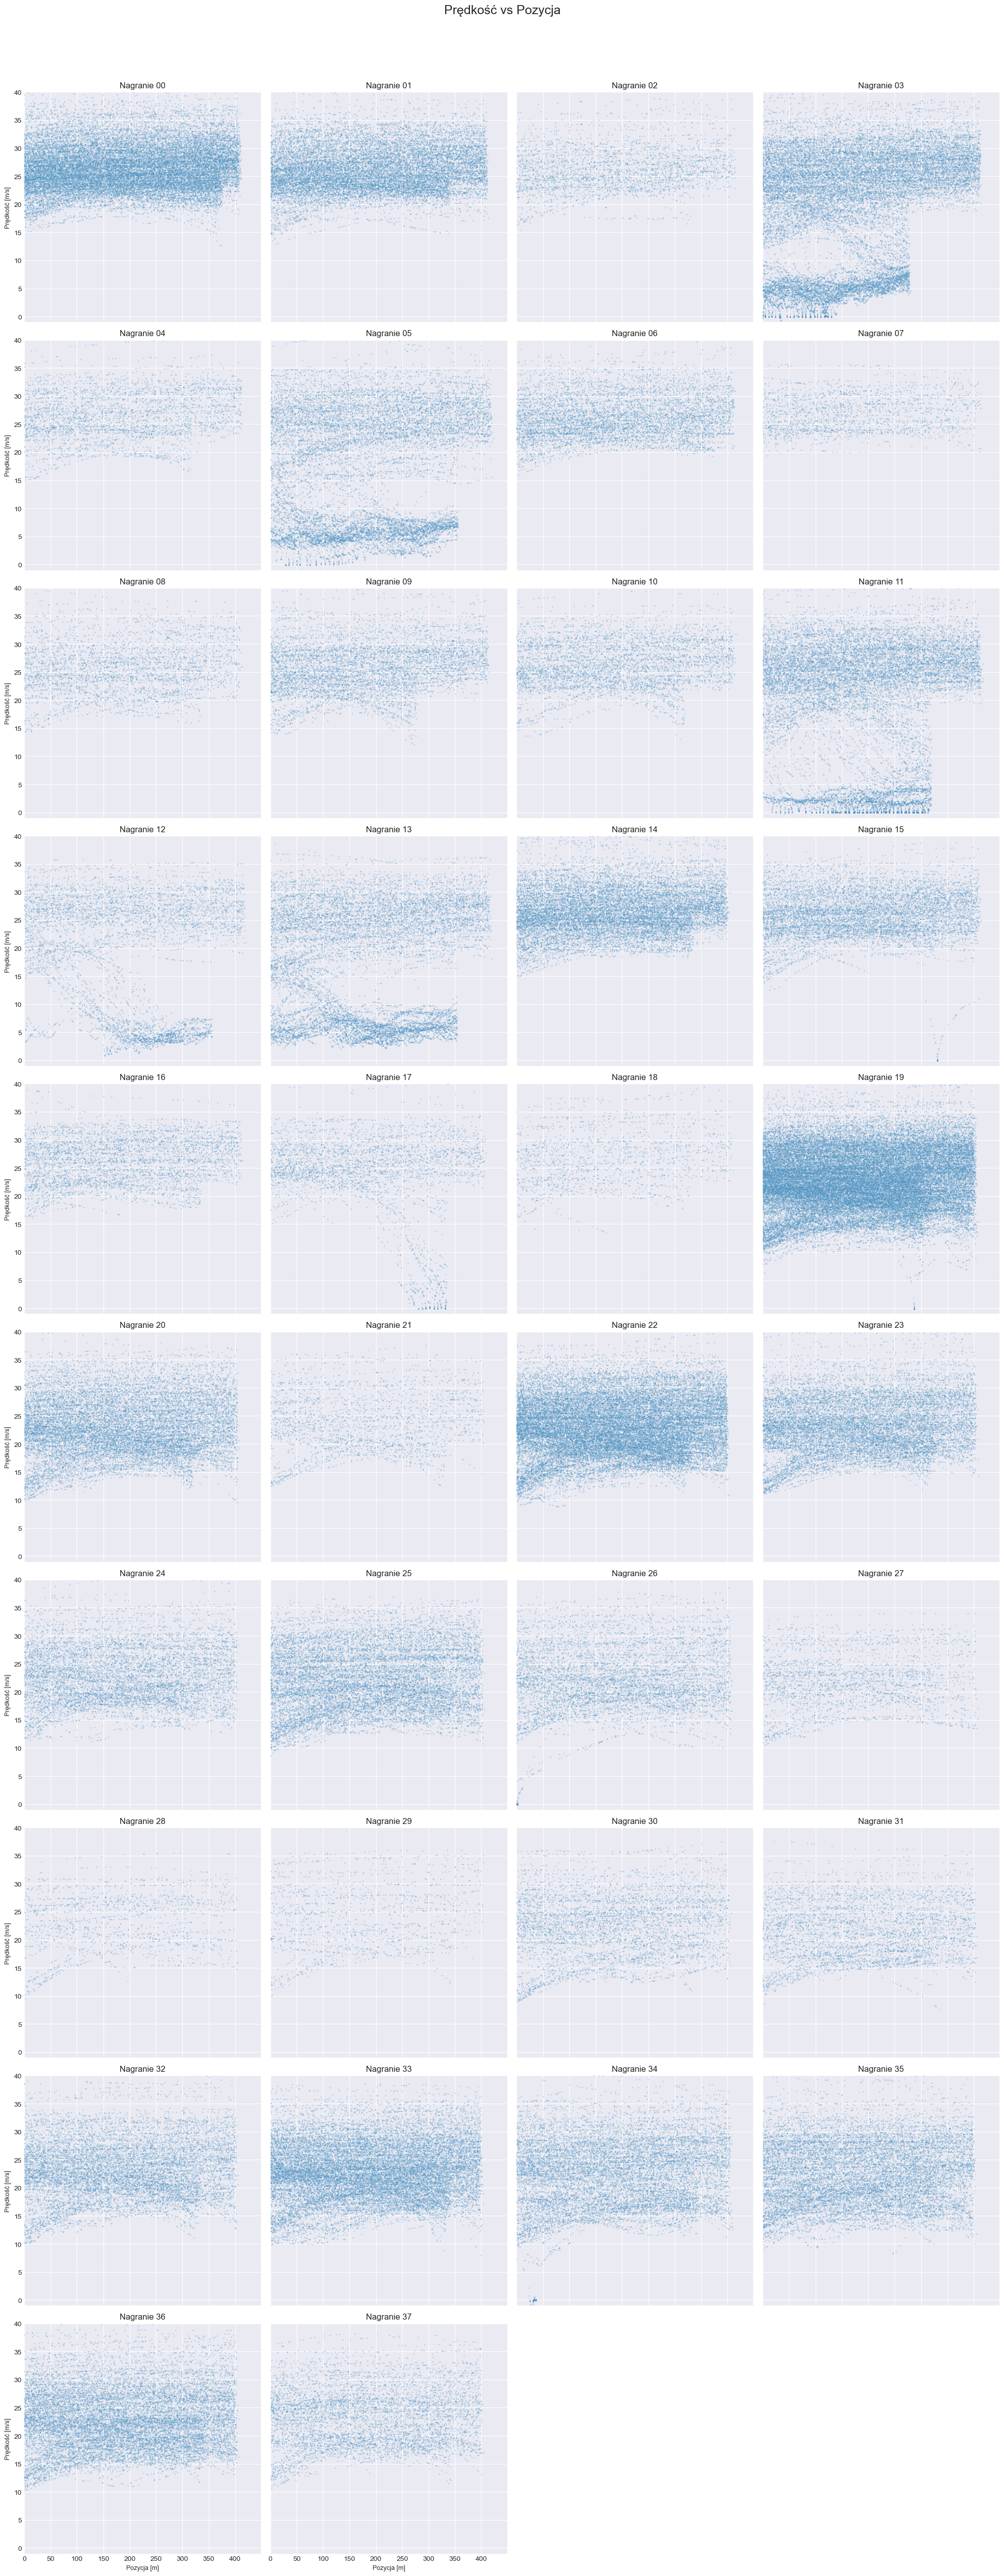

In [1266]:
print("Weryfikacja korków...")

if 'tracks_df' in locals() and tracks_df is not None:
    tracks_df['s_center'] = tracks_df['traveledDistance']

    unique_ids = sorted(tracks_df['recordingId'].unique())
    num_ids = len(unique_ids)

    cols = 4
    rows = (num_ids + cols - 1) // cols 

    print(f"\nZnaleziono {num_ids} nagrań do wizualizacji.")

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True, sharey=True)
    ax_flat = axes.flat

    # Używamy zmiennej iteracyjnej 'i' do poprawnego ukrycia pustych osi
    i = 0
    for rec_id in unique_ids:
        ax = ax_flat[i] 
        df_rec = tracks_df[tracks_df['recordingId'] == rec_id]
        
        if df_rec.empty:
            ax.set_title(f"Nagranie {rec_id} (brak danych)")
            i += 1
            continue

        # Użycie mniejszej próbki dla wydajności
        sample_rec_df = df_rec.sample(frac=0.05, random_state=42)
        
        # *** Używamy 's_center' (czyli 'traveledDistance') ***
        sns.scatterplot(data=sample_rec_df, x='s_center', y='lonVelocity',
                        s=3, alpha=0.3, ax=ax, legend=False)
        
        ax.set_title(f"Nagranie {rec_id}")
        ax.set_xlabel('Pozycja [m]', fontsize=9)
        ax.set_ylabel('Prędkość [m/s]', fontsize=9)
        
        i += 1 # Inkrementacja indeksu po udanym wykresie

    # Ukrywanie pustych podwykresów
    for j in range(i, len(ax_flat)):
        ax_flat[j].set_visible(False)
        
    # Ustawienie limitów osi X i Y
    plt.xlim(0, tracks_df['s_center'].max() * 1.05 if not tracks_df['s_center'].empty else 1100) 
    plt.ylim(-1, 40) 
    plt.suptitle('Prędkość vs Pozycja', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Brak danych")

Mapa geometrii...
Wizualizacja dla 404574 punktów


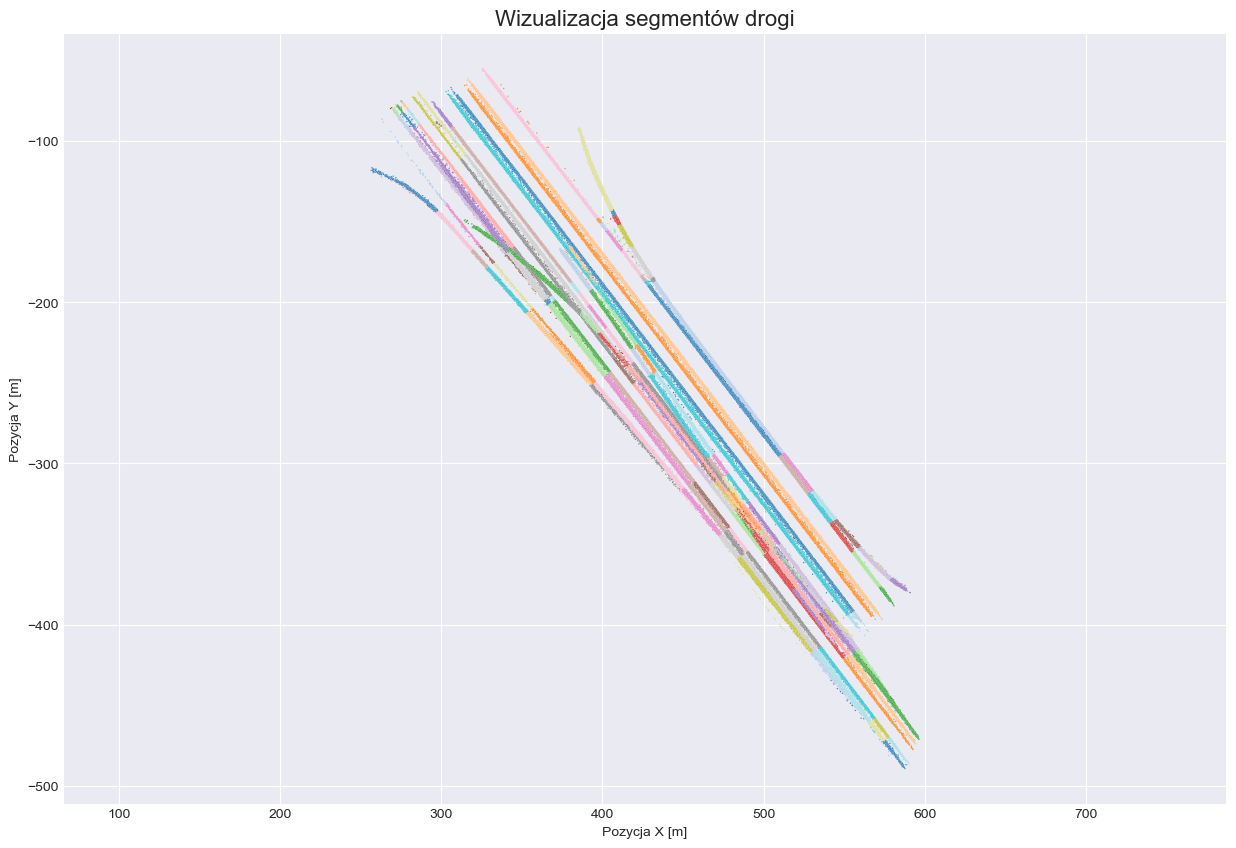

In [1267]:
print("Mapa geometrii...")

if 'tracks_df' in locals() and tracks_df is not None:
    sample_df = tracks_df.sample(frac=0.05, random_state=42)
    print(f"Wizualizacja dla {len(sample_df)} punktów")
    
    plt.figure(figsize=(15, 10))
    sns.scatterplot(data=sample_df, x='xCenter', y='yCenter', 
    # sns.scatterplot(data=sample_df, x='s_center', y='latLaneCenterOffset', 
                    hue='laneletId', palette='tab20', s=1, legend=False)
    
    plt.title('Wizualizacja segmentów drogi', fontsize=16)
    plt.xlabel('Pozycja X [m]')
    plt.ylabel('Pozycja Y [m]')
    plt.axis('equal')
    plt.show()
else:
    print("Brak danych")

# Kalibracja parametrów NaSch

Kalibracja parametrów modelu:
- v_max - maksymalna prędkość
- p - prawdopodobieństwo losowego hamowania

In [1268]:
print("Wybór nagrania i laneleta\n")

print(f"Nagranie: {TARGET_RECORDING_ID}")

if 'tracks_df' in locals() and tracks_df is not None:
    df_target_rec = tracks_df[tracks_df['recordingId'] == TARGET_RECORDING_ID].copy()
    print(f"Pomiarów: {len(df_target_rec)}")
    print(f"Pojazdów: {df_target_rec['trackId'].nunique()}")
    print(f"Laneletów: {df_target_rec['laneletId'].nunique()}")
    
    lanelet_counts = df_target_rec.groupby('laneletId').size().sort_values(ascending=False)
    print("\nTop 10 laneletów:")
    print(lanelet_counts.head(10))
    
    test_lanelet_id = lanelet_counts.index[0]
    
    test_length_m = df_target_rec[df_target_rec['laneletId'] == test_lanelet_id]['laneletLength'].max()
    
    print(f"\nWybrany lanelet: {test_lanelet_id}")
    print(f"Liczba pomiarów: {lanelet_counts.iloc[0]}")
    print(f"Długość: {test_length_m:.1f} m")
else:
    print("Błąd: brak danych")

Wybór nagrania i laneleta

Nagranie: 05
Pomiarów: 265302
Pojazdów: 478
Laneletów: 84

Top 10 laneletów:
laneletId
1918    23922
1703    23922
1709    16461
1687    11391
1913    10142
1697     9412
1957     9347
1706     8040
1951     7072
1696     6848
dtype: int64

Wybrany lanelet: 1918
Liczba pomiarów: 23922
Długość: 81.2 m


In [1269]:
print("Agregacja danych w biny czasowe\n")

if 'df_target_rec' in locals() and test_lanelet_id is not None:
    test_df = df_target_rec[df_target_rec['laneletId'] == test_lanelet_id].copy()
        
    FPS = 25
    TIME_BIN = 300
        
    print(f"FPS: {FPS}")
    print(f"Bin czasowy: {TIME_BIN} klatek ({TIME_BIN/FPS:.1f} s)")
    print(f"Długość komórki: {CELL_LENGTH_M} m")

    # --- KROK 1: Obliczanie Przepływu (Flow) za pomocą Wirtualnej Linii Pomiarowej ---

    # 1a. Definicja Wirtualnej Linii Mety (np. 1 metr przed końcem laneletu)
    S_META = test_length_m - 6.0 # Wybieramy linię pomiarową na końcu segmentu

    # 1b. Sortowanie i Obliczanie Pozycji w Poprzedniej Klatce
    # Dane muszą być posortowane według pojazdu i czasu
    flow_tracking_df = test_df.sort_values(['trackId', 'frame']).copy()

    # Obliczanie pozycji xCenter w poprzedniej klatce DLA TEGO SAMEGO POJAZDU
    flow_tracking_df['prev_lonLaneletPos'] = flow_tracking_df.groupby('trackId')['lonLaneletPos'].shift(1)

    # 1c. Zliczanie Zdarzeń Przekroczenia Mety
    # Przejście (flow event) występuje, jeśli:
    # 1) W poprzedniej klatce pojazd był przed linią mety (prev_xCenter < X_META)
    # 2) W obecnej klatce pojazd jest za linią mety (xCenter >= X_META)
    # 3) To przejście jest w kierunku do przodu (xCenter > prev_xCenter)
    flow_tracking_df['flow_event'] = np.where(
        (flow_tracking_df['prev_lonLaneletPos'] < S_META) & 
        (flow_tracking_df['lonLaneletPos'] >= S_META) &
        (flow_tracking_df['lonLaneletPos'] > flow_tracking_df['prev_lonLaneletPos']), 
        1, 
        0
    )

    # 1d. Przypisanie Binu Czasowego do Zdarzenia Przepływu
    flow_tracking_df['time_bin'] = (flow_tracking_df['frame'] // TIME_BIN) * TIME_BIN

    # 1e. Agregacja Zdarzeń Przepływu do Binu
    flow_per_bin = flow_tracking_df.groupby('time_bin')['flow_event'].sum().reset_index(name='flow_count')


    # --- KROK 2: Przygotowanie Danych dla Gęstości (Density) (Mediana) ---

    # Etap 2a: Oblicz unikalne pojazdy dla każdej klatki ('frame')
    frame_n_vehicles = test_df.groupby('frame')['trackId'].nunique().reset_index(name='n_vehicles_per_frame')
    frame_n_vehicles['time_bin'] = (frame_n_vehicles['frame'] // TIME_BIN) * TIME_BIN

    # Etap 2b: Oblicz MEDIANĘ N pojazdów dla każdego binu
    median_n_vehicles_per_bin = frame_n_vehicles.groupby('time_bin')['n_vehicles_per_frame'].mean().reset_index(name='median_n_vehicles')


    # --- KROK 3: Iteracja i Finalne Obliczenia ---

    # Utworzenie DataFrame'u do iteracji poprzez połączenie danych o medianie i flow_count
    # Używamy MEDIANY jako bazy do obliczenia Gęstości
    # Używamy FLOW_COUNT do obliczenia Przepływu
    stats_base = pd.merge(median_n_vehicles_per_bin, flow_per_bin, on='time_bin', how='left').fillna(0)

    test_df['time_bin'] = (test_df['frame'] // TIME_BIN) * TIME_BIN
    # Potrzebujemy również średniej prędkości dla każdego binu (z całego oryginalnego df)
    avg_speed_per_bin = test_df.groupby('time_bin')['lonVelocity'].mean().reset_index(name='avg_speed_m_s')
    stats_base = pd.merge(stats_base, avg_speed_per_bin, on='time_bin', how='left')


    time_duration_s = TIME_BIN / FPS
    # cells_in_lanelet = test_length_m / CELL_LENGTH_M

    segment_stats = []

    for index, row in stats_base.iterrows():
        
        # Gęstość (k) w jednostkach NaSch [pojazdy/komórkę]
        occupancy = (row['median_n_vehicles'] / test_length_m) * 1000
            
        # Przepływ (q) [pojazdy/s]
        # Liczba Zliczonych Przejść (flow_count) podzielona przez Czas Trwania Binu
        flow = (row['flow_count'] / time_duration_s)  * 3600
            
        segment_stats.append({
            'time_bin': row['time_bin'],
            'time_s': row['time_bin'] / FPS,
            'n_vehicles_median': row['median_n_vehicles'],
            'flow_count_total': row['flow_count'], # Dodatkowa informacja o surowej liczbie przejść
            'avg_speed_m_s': row['avg_speed_m_s'],
            'density': occupancy,  # pojazdy/komórkę (używa mediany)
            'flow': flow  # pojazdy/s (używa zliczonych przejść)
        })
        
    segment_stats = pd.DataFrame(segment_stats)
        
    print(f"\nBinów czasowych: {len(segment_stats)}")
    print("\nStatystyki:")
    print(segment_stats.describe())
    print("\nPierwsze 5 binów:")
    # Wyświetlamy flow_count_total, aby weryfikować poprawność obliczeń
    print(segment_stats[['time_s', 'n_vehicles_median', 'flow_count_total', 'flow', 'density', 'avg_speed_m_s']].head())
else:
    print("Błąd: brak danych")

Agregacja danych w biny czasowe

FPS: 25
Bin czasowy: 300 klatek (12.0 s)
Długość komórki: 7.5 m

Binów czasowych: 20

Statystyki:
          time_bin      time_s  n_vehicles_median  flow_count_total  \
count    20.000000   20.000000          20.000000         20.000000   
mean   2850.000000  114.000000           4.081446          3.950000   
std    1774.823935   70.992957           1.972923          1.700619   
min       0.000000    0.000000           1.000000          0.000000   
25%    1425.000000   57.000000           2.720833          3.000000   
50%    2850.000000  114.000000           4.101667          4.000000   
75%    4275.000000  171.000000           4.980833          5.000000   
max    5700.000000  228.000000           8.660000          8.000000   

       avg_speed_m_s     density         flow  
count      20.000000   20.000000    20.000000  
mean        9.611012   50.251741  1185.000000  
std         6.955856   24.291096   510.185725  
min         1.638201   12.312238     

Diagram fundamentalny



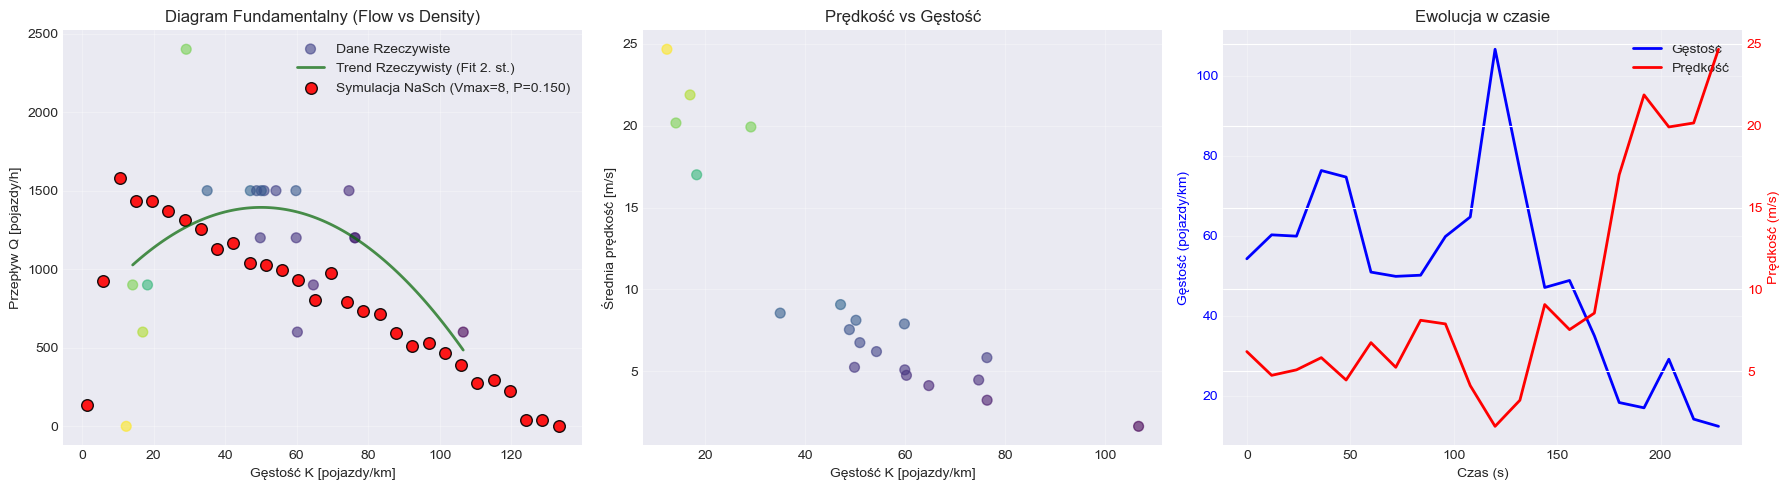


Max gęstość: 106.624
Max przepływ: 2400.000000
Średnia prędkość: 9.61 m/s
Max prędkość: 24.68 m/s


In [1270]:
print("Diagram fundamentalny\n")

SIMULATION_FILE_PATH = '../data/nasch_sim_K_Q.csv'
try:
    sim_df = pd.read_csv(SIMULATION_FILE_PATH)
    # Zmieniamy nazwy kolumn, by pasowały do reszty kodu:
    K_sim = sim_df['Density_K_poj_km']
    Q_sim = sim_df['Flow_Q_poj_h']
    
    # Próba odczytania parametrów symulacji do etykiety
    V_max_sim = sim_df['V_max_sim'].iloc[0] if 'V_max_sim' in sim_df.columns else '?'
    P_sim = sim_df['P_sim'].iloc[0] if 'P_sim' in sim_df.columns else '?'

except FileNotFoundError:
    print(f"⚠️ Błąd: Plik symulacji nie został znaleziony pod ścieżką: {SIMULATION_FILE_PATH}")
    sim_df = None
except Exception as e:
    print(f"⚠️ Błąd podczas wczytywania pliku symulacji: {e}")
    sim_df = None

if 'segment_stats' in locals() and segment_stats is not None:
    # x_min = 0 
    x_min = segment_stats['density'].min() * 0.95
    # Używamy .max() z kolumny gęstości i dodajemy 5% marginesu
    x_max = segment_stats['density'].max() * 1.05
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    # Dane Rzeczywiste (punkty kolorowane prędkością)
    axes[0].scatter(segment_stats['density'], segment_stats['flow'], 
                    alpha=0.6, s=50, 
                    c=segment_stats['avg_speed_m_s'], cmap='viridis', 
                    label='Dane Rzeczywiste')
    
    # --- DODANIE LINII TRENDU DLA DANYCH RZECZYWISTYCH ---
    
    # Usuwamy wiersze z zerowym przepływem (często szum w danych)
    real_data_for_fit = segment_stats[(segment_stats['flow'] > 50) & (segment_stats['density'] > 0)].copy()
    
    if len(real_data_for_fit) > 3:
        # Dopasowanie wielomianu 2. stopnia (parabola) do danych rzeczywistych
        K_real = real_data_for_fit['density'].values
        Q_real = real_data_for_fit['flow'].values
        
        # Obliczanie współczynników regresji
        coeffs_real = np.polyfit(K_real, Q_real, 2)
        poly_real = np.poly1d(coeffs_real)
        
        # Generowanie punktów dla krzywej
        K_range = np.linspace(K_real.min(), K_real.max(), 100)
        Q_fit_real = poly_real(K_range)
        
        axes[0].plot(K_range, Q_fit_real, color='darkgreen', linestyle='-', linewidth=2, 
                     label='Trend Rzeczywisty (Fit 2. st.)', alpha=0.7)
    
    # DODANIE DANYCH SYMULACYJNYCH
    if sim_df is not None:
        axes[0].scatter(K_sim, Q_sim, 
                        alpha=0.9, s=70, 
                        c='red', marker='o', edgecolors='black', 
                        label=f'Symulacja NaSch (Vmax={V_max_sim}, P={P_sim:.3f})')
        
        # --- DODANIE LINII TRENDU DLA SYMULACJI ---
        
        # Dopasowanie wielomianu 2. stopnia do danych symulacji
        K_sim_arr = K_sim.values
        Q_sim_arr = Q_sim.values
        
        # Wybieramy tylko punkty, które nie są zerowe (zator)
        sim_data_for_fit = sim_df[sim_df['Flow_Q_poj_h'] > 10].copy() 

        if len(sim_data_for_fit) > 3:
            coeffs_sim = np.polyfit(sim_data_for_fit['Density_K_poj_km'], sim_data_for_fit['Flow_Q_poj_h'], 2)
            poly_sim = np.poly1d(coeffs_sim)
            
            K_range_sim = np.linspace(sim_data_for_fit['Density_K_poj_km'].min(), sim_data_for_fit['Density_K_poj_km'].max(), 100)
            Q_fit_sim = poly_sim(K_range_sim)
            
            # axes[0].plot(K_range_sim, Q_fit_sim, color='purple', linestyle='--', linewidth=2, 
            #              label='Trend Symulacji (Fit 2. st.)', alpha=0.9)


    # DYNAMICZNE OGRANICZENIE OSI POZIOMEJ (X)
    # axes[0].set_xlim(x_min, x_max)

    axes[0].set_xlabel('Gęstość K [pojazdy/km]')
    axes[0].set_ylabel('Przepływ Q [pojazdy/h]')
    axes[0].set_title('Diagram Fundamentalny (Flow vs Density)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right')
    
    # ------------------------------------------------
    # 2. SPEED vs DENSITY (Można tu też dodać fit, ale zostawiamy tylko punkty dla uproszczenia)
    # ------------------------------------------------
    
    axes[1].scatter(segment_stats['density'], segment_stats['avg_speed_m_s'], 
                    alpha=0.6, s=50, c=segment_stats['avg_speed_m_s'], cmap='viridis')
    # axes[1].set_xlim(x_min, x_max) 
    axes[1].set_xlabel('Gęstość K [pojazdy/km]')
    axes[1].set_ylabel('Średnia prędkość [m/s]')
    axes[1].set_title('Prędkość vs Gęstość')
    axes[1].grid(True, alpha=0.3)
    
    # ------------------------------------------------
    # 3. TIME EVOLUTION (Bez zmian)
    # ------------------------------------------------
    
    ax3 = axes[2]
    ax3_twin = ax3.twinx()
    
    line1 = ax3.plot(segment_stats['time_s'], segment_stats['density'], 
                      'b-', label='Gęstość', linewidth=2)
    line2 = ax3_twin.plot(segment_stats['time_s'], segment_stats['avg_speed_m_s'], 
                          'r-', label='Prędkość', linewidth=2)
    
    ax3.set_xlabel('Czas (s)')
    ax3.set_ylabel('Gęstość (pojazdy/km)', color='b')
    ax3_twin.set_ylabel('Prędkość (m/s)', color='r')
    ax3.set_title('Ewolucja w czasie')
    ax3.tick_params(axis='y', labelcolor='b')
    ax3_twin.tick_params(axis='y', labelcolor='r')
    ax3.grid(True, alpha=0.3)
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax3.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nMax gęstość: {segment_stats['density'].max():.3f}")
    print(f"Max przepływ: {segment_stats['flow'].max():.6f}")
    print(f"Średnia prędkość: {segment_stats['avg_speed_m_s'].mean():.2f} m/s")
    print(f"Max prędkość: {segment_stats['avg_speed_m_s'].max():.2f} m/s")
else:
    print("Błąd: brak danych")

In [1271]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- KROK 1: Upewnienie się, że dane i fit istnieją ---

if sim_df is not None and 'poly_real' in locals():
    
    # ----------------------------------------------------
    # Walidacja Modelu Symulacyjnego (NaSch) vs Dane Rzeczywiste
    # ----------------------------------------------------
    
    # 1. Przygotowanie danych symulacyjnych
    # Porównujemy przepływ Q symulacji z teoretycznym Q obliczonym z fitu danych rzeczywistych
    K_sim_arr = K_sim.values # Gęstość symulacji
    Q_sim_arr = Q_sim.values # Przepływ symulacji
    
    # 2. Obliczanie przepływu referencyjnego (Q_ref)
    # Obliczamy, jaki przepływ P_ref powinien mieć dla danej gęstości K_sim, 
    # bazując na dopasowanej krzywej (poly_real) danych rzeczywistych.
    
    # Zabezpieczenie: Przycinamy K_sim do zakresu, w którym został wykonany fit_real
    k_min_fit = real_data_for_fit['density'].min()
    k_max_fit = real_data_for_fit['density'].max()

    # Filtrujemy punkty symulacji, które są poza zakresem pomiarowym danych rzeczywistych
    valid_indices = (K_sim_arr >= k_min_fit) & (K_sim_arr <= k_max_fit)
    
    K_sim_valid = K_sim_arr[valid_indices]
    Q_sim_valid = Q_sim_arr[valid_indices]
    
    if len(Q_sim_valid) == 0:
        print("\n⚠️ Nie można obliczyć błędów: Brak punktów symulacji w zakresie gęstości danych rzeczywistych.")
    else:
        # Obliczanie wartości referencyjnych Q na podstawie fitu rzeczywistego
        Q_ref_real = poly_real(K_sim_valid)
        
        # 3. Obliczanie Błędów
        
        # RMSE: Pierwiastek ze średniej kwadratów błędów. Mocniej karze duże błędy.
        rmse = np.sqrt(mean_squared_error(Q_ref_real, Q_sim_valid))
        
        # MAE: Średnia wartość bezwzględna błędu. Bardziej intuicyjna.
        mae = mean_absolute_error(Q_ref_real, Q_sim_valid)

        print("\n===========================================")
        print("📊 Walidacja Modelu NaSch (vs Trend Rzeczywisty)")
        print("===========================================")
        print(f"Liczba porównywanych punktów: {len(Q_sim_valid)}")
        print(f"Średni Błąd Kwadratowy (RMSE): **{rmse:.1f} poj/h**")
        print(f"Średni Błąd Bezwzględny (MAE): **{mae:.1f} poj/h**")
        print("===========================================")

else:
    print("\nNie można obliczyć błędów: Brak danych symulacyjnych lub brak dopasowanego trendu (poly_real).")


📊 Walidacja Modelu NaSch (vs Trend Rzeczywisty)
Liczba porównywanych punktów: 21
Średni Błąd Kwadratowy (RMSE): **326.6 poj/h**
Średni Błąd Bezwzględny (MAE): **300.0 poj/h**


In [1272]:
print("Wyznaczenie parametrów v_max i p\n")

if 'test_df' in locals() and test_df is not None:
    
    # v_max
    test_df['v_nasch'] = (test_df['lonVelocity'] * TIME_STEP_S) / CELL_LENGTH_M
    v_max_empirical_float = test_df['v_nasch'].quantile(0.95)
    v_max = int(np.ceil(v_max_empirical_float))
    
    v_max_m_s = test_df['lonVelocity'].quantile(0.95)
    
    print("Kalibracja v_max:")
    print(f"  95-ty percentyl: {v_max_empirical_float:.2f} komórek/krok")
    print(f"  v_max: {v_max} komórek/krok")
    print(f"  Maksymalna prędkość: {v_max_m_s:.1f} m/s ({v_max_m_s * 3.6:.1f} km/h)")
    
    # p
    mean_speed = test_df['lonVelocity'].mean()
    std_speed = test_df['lonVelocity'].std()
    cv = std_speed / mean_speed if mean_speed > 0 else 0
    p_estimated = np.clip(cv * 0.5, 0.05, 0.5)
    
    print("\nKalibracja p:")
    print(f"  Średnia prędkość: {mean_speed:.2f} m/s")
    print(f"  Odchylenie standardowe: {std_speed:.2f}")
    print(f"  Współczynnik zmienności: {cv:.3f}")
    print(f"  Estymowane p: {p_estimated:.3f}")
    
    # Analiza hamowania
    ACCEL_THRESHOLD = -0.2
    deceleration_events = (test_df['lonAcceleration'] < ACCEL_THRESHOLD).sum()
    total_events = len(test_df) 
    p_from_deceleration = deceleration_events / total_events if total_events > 0 else 0.15
    
    print(f"\n  Analiza hamowania:")
    print(f"  Zdarzenia hamowania: {deceleration_events}")
    print(f"  Łączna liczba zdarzeń: {total_events}")
    print(f"  p z hamowania: {p_from_deceleration:.3f}")
    
    p_final = (p_estimated + p_from_deceleration) / 2
    p_final = np.clip(p_final, 0.05, 0.5)
    
    print(f"\nFINALNE PARAMETRY:")
    print(f"  v_max = {v_max} komórek/krok")
    print(f"  p = {p_final:.3f}")
    print(f"\nInterpretacja:")
    print(f"  Max prędkość: {v_max * CELL_LENGTH_M / TIME_STEP_S * 3.6:.0f} km/h")
    print(f"  Hamowanie co ~{1/p_final:.1f} krok")
    
    K = p_final
else:
    print("Błąd: brak danych")

Wyznaczenie parametrów v_max i p

Kalibracja v_max:
  95-ty percentyl: 3.76 komórek/krok
  v_max: 4 komórek/krok
  Maksymalna prędkość: 17.6 m/s (63.4 km/h)

Kalibracja p:
  Średnia prędkość: 6.41 m/s
  Odchylenie standardowe: 4.53
  Współczynnik zmienności: 0.707
  Estymowane p: 0.354

  Analiza hamowania:
  Zdarzenia hamowania: 11855
  Łączna liczba zdarzeń: 23922
  p z hamowania: 0.496

FINALNE PARAMETRY:
  v_max = 4 komórek/krok
  p = 0.425

Interpretacja:
  Max prędkość: 68 km/h
  Hamowanie co ~2.4 krok


Rozkłady prędkości



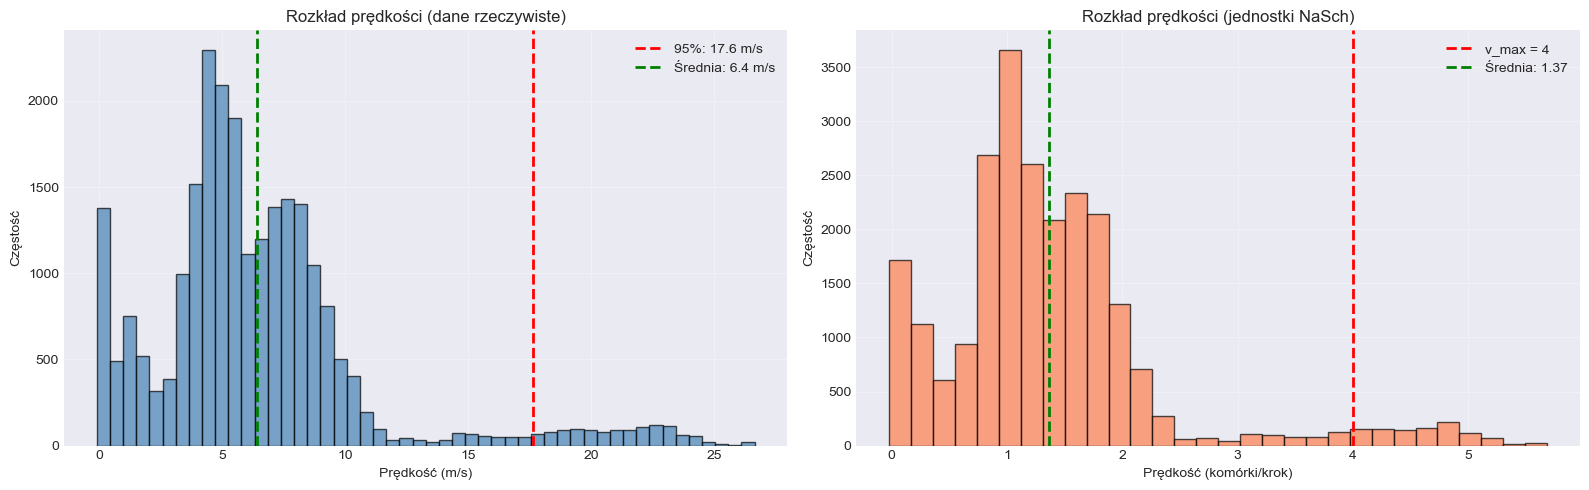

Statystyki:
  Min: -0.10 m/s
  25%: 4.05 m/s
  Mediana: 5.56 m/s
  75%: 7.99 m/s
  95%: 17.62 m/s
  Max: 26.63 m/s


In [1273]:
print("Rozkłady prędkości\n")

if 'test_df' in locals() and 'v_max' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Histogram m/s
    axes[0].hist(test_df['lonVelocity'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(test_df['lonVelocity'].quantile(0.95), color='red', linestyle='--', 
                    linewidth=2, label=f'95%: {test_df["lonVelocity"].quantile(0.95):.1f} m/s')
    axes[0].axvline(test_df['lonVelocity'].mean(), color='green', linestyle='--', 
                    linewidth=2, label=f'Średnia: {test_df["lonVelocity"].mean():.1f} m/s')
    axes[0].set_xlabel('Prędkość (m/s)')
    axes[0].set_ylabel('Częstość')
    axes[0].set_title('Rozkład prędkości (dane rzeczywiste)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Histogram jednostki NaSch
    axes[1].hist(test_df['v_nasch'], bins=30, alpha=0.7, color='coral', edgecolor='black')
    axes[1].axvline(v_max, color='red', linestyle='--', 
                    linewidth=2, label=f'v_max = {v_max}')
    axes[1].axvline(test_df['v_nasch'].mean(), color='green', linestyle='--', 
                    linewidth=2, label=f'Średnia: {test_df["v_nasch"].mean():.2f}')
    axes[1].set_xlabel('Prędkość (komórki/krok)')
    axes[1].set_ylabel('Częstość')
    axes[1].set_title('Rozkład prędkości (jednostki NaSch)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Statystyki:")
    print(f"  Min: {test_df['lonVelocity'].min():.2f} m/s")
    print(f"  25%: {test_df['lonVelocity'].quantile(0.25):.2f} m/s")
    print(f"  Mediana: {test_df['lonVelocity'].median():.2f} m/s")
    print(f"  75%: {test_df['lonVelocity'].quantile(0.75):.2f} m/s")
    print(f"  95%: {test_df['lonVelocity'].quantile(0.95):.2f} m/s")
    print(f"  Max: {test_df['lonVelocity'].max():.2f} m/s")
else:
    print("Błąd: brak danych")

In [1274]:
def calibrate_lane_change_params(tracks_df, cell_length_m, time_step_s):
    """
    Kalibruje parametry motywacji (DV_min) i bezpieczeństwa (Gap_rear) 
    dla rozszerzonego modelu NaSch.
    """
    # 1. Filtrowanie danych do analizy zmian pasa (laneChange != 0)
    # Wybieramy tylko te chwile, w których ZMIANA PASA się odbywa lub ma zacząć
    lc_df = tracks_df[tracks_df['laneChange'] != 0].copy()

    if lc_df.empty:
        print("Brak zdarzeń zmiany pasa (laneChange != 0) w danych. Użyto domyślnych wartości.")
        return {'DV_min': 2.0, 'Gap_rear_nasch': 2}


    # --- PARAMETR 1: MOTYWACJA (DV_min w m/s) ---
    
    # Motywacja jest mierzona przez różnicę prędkości do samochodu prowadzącego (leadDV)
    # w momencie podjęcia decyzji. W NaSch chcemy to przekształcić na v_nasch.
    
    # leadDV: Różnica prędkości między pojazdem prowadzącym a Twoim pojazdem (V_lead - V_self).
    # Jeśli V_lead > V_self, leadDV jest dodatnie.
    # Jeśli V_self jest hamowany przez V_lead, leadDV jest ujemne.
    
    # Chcemy znaleźć medianę |leadDV| dla wszystkich, którzy zmienili pas, 
    # gdy ich prędkość była ograniczona (leadDV < 0).
    
    # 1a. Filtrujemy tylko przypadki, gdy pojazd z przodu był wolniejszy (hamował nas)
    motivation_df = lc_df[lc_df['leadDV'] < 0].copy()
    
    if motivation_df.empty:
        print("Brak zdarzeń zmiany pasa, w których pojazd był hamowany. DV_min = 0.")
        dv_min_ms = 0.0
    else:
        # 1b. Obliczanie utraconej prędkości (różnica prędkości)
        # Bierzemy medianę BEZWZGLĘDNEJ wartości leadDV
        dv_min_ms = motivation_df['leadDV'].abs().median()

    # Przeliczenie na jednostki NaSch: (m/s * TIME_STEP_S) / CELL_LENGTH_M
    DV_MIN_NASCH = (dv_min_ms * time_step_s) / cell_length_m
    print(dv_min_ms)
    # Minimalna różnica musi wynosić co najmniej 1 jednostkę NaSch (np. 1 komórka/krok)
    # DV_MIN_NASCH = np.ceil(max(DV_MIN_NASCH, 0)) 


    # --- PARAMETR 2: BEZPIECZEŃSTWO (Gap_rear) ---

    # Mierzymy minimalny akceptowalny bufor (TTC lub THW) pozostawiony 
    # za zmieniającym pas na pasie docelowym.
    
    # Używamy kolumny 'leftRearId' lub 'rightRearId' do identyfikacji pojazdu z tyłu
    # oraz 'leadTHW' (Time Headway) dla ogólnej charakterystyki odstępów czasowych.
    
    # Tutaj skupiamy się na TYLNYM pojeździe na NOWYM pasie.
    # Niestety, EXID nie ma gotowego THW/DHW dla 'Rear' na 'Left'/'Right' pasie, 
    # więc musimy polegać na ogólnych statystykach.
    
    # Uproszczona kalibracja: Mierzymy minimalny akceptowalny odstęp czasowy (TTC/THW)
    # W praktyce modelu CA, minimalny bezpieczny dystans to 2 komórki. 
    # Kalibrujemy to na podstawie mediany najmniejszych odstępów.
    
    # 2a. Obliczenie minimalnego akceptowalnego opóźnienia komfortowego (A_max_comfort)
    # Wybieramy opóźnienia (ujemne lonAcceleration) z ruchu swobodnego (leadTHW > 5s) 
    # i bierzemy medianę tych opóźnień (wartość bezwzględną).
    # To jest parametr, który określa maksymalne opóźnienie, jakie jest akceptowane
    
    decel_for_safety = tracks_df[
        (tracks_df['leadTHW'] > 5) & # ruch swobodny lub minimalne oddziaływanie
        (tracks_df['lonAcceleration'] < -0.1) 
    ]['lonAcceleration'].abs().mean()
    
    # Jeśli nie znaleziono, użyj stałej
    A_MAX_COMFORT = max(decel_for_safety, 0) # m/s^2 (Używamy co najmniej 1.5 m/s^2)
    
    # 2b. Konwersja do stałej luki bezpieczeństwa NaSch:
    # W modelu CA, parametr bezpieczeństwa często jest stałą (min. luką w komórkach)
    # 2 komórki to standardowa minimalna luka do bezpiecznego wjazdu.
    GAP_REAR_NASCH = 2 # komórki (Standardowa bezpieczna luka w NaSch)
    
    return {
        'DV_min_nasch': DV_MIN_NASCH,
        'DV_min_ms': dv_min_ms,
        'Gap_rear_nasch': GAP_REAR_NASCH,
        'A_max_comfort_m_s2': A_MAX_COMFORT
    }


calibration_params = calibrate_lane_change_params(tracks_df, CELL_LENGTH_M, TIME_STEP_S)
print("\n--- Parametry Zmiany Pasa (Kalibracja) ---")
print(f"Motywacja (V_strat): {calibration_params['DV_min_nasch']:.1f} jednostek NaSch (co najmniej 1)")
print(f"Minimalna luka z tyłu (Gap_rear): {calibration_params['Gap_rear_nasch']} komórki")
print(f"Akceptowalne opóźnienie komfortowe: {calibration_params['A_max_comfort_m_s2']:.2f} m/s^2")

4.86

--- Parametry Zmiany Pasa (Kalibracja) ---
Motywacja (V_strat): 1.0 jednostek NaSch (co najmniej 1)
Minimalna luka z tyłu (Gap_rear): 2 komórki
Akceptowalne opóźnienie komfortowe: 0.31 m/s^2
